# NLP tools for Twitter

#### The first portion:
Consists of scripts to connect to Twitter's API and to pull the last 3200 Tweets from any given account, then storing these tweets into a CSV with a bit of metadata.

**NEW!** 6/5/17 built a search scraper off of Twitter's REST API to pull, filter, and store tweets from query(s) or search term(s) of your choice.

#### The second portion:
Consists of functions I've developed to clean and parse these tweets into a format suited for analysis and for use in the context of deep learning / machine learning applications.

#### The third portion:
Borrows from the embedding and word2vec lessons from Udacity's Deep Learning Nanodegree. In this portion, we build an embedding network with Tensorflow that 'learns' the relationship between words in the corpus of tweets from a particular user. This is more of a thought experiment to see if we can develop a better understanding of a particular user's worldview through the way they express themselves via Twitter.

#### The fourth portion 
Will be dedicated to building a seq2seq network to generate new tweets in the style of the target user(s) tweets.

In [2]:
import numpy as np
import matplotlib as plt
import sklearn
import tensorflow as tf
import tweepy 
import time
import csv
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
import random

# Section 1:
Get the API keys set up and test to make sure things are running smoothly

**NEW!** adding some other helper functions

In [3]:
# Before using these functions, you'll need to get your own API keys from
# Twitter - https://dev.twitter.com/oauth/overview
consumer_key = 'consumer_key'
consumer_secret = 'consumer_secret'

access_token = 'access_token'
access_secret = 'access_secret'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

public_tweets = api.home_timeline()
tweet_bucket = [tweet.text for tweet in public_tweets]

print(tweet_bucket[:5])

['Google Home now has a screen — and Spotify https://t.co/4ub1nxZO4l https://t.co/ILe6bRVGA0', 'Google will let you search LinkedIn, Monster, Facebook, and more job sites all at once https://t.co/DKT0cvRxgY https://t.co/SqndE62r3p', 'McCaw does best Iguodala imitation in Game 2 win https://t.co/D4UlXfKBxK https://t.co/OSUuOS7N5h', "'In the right place at the right time:' Tow truck driver helps secure SUV dangling off I-5 https://t.co/tEQRbCXN3j… https://t.co/A5UAa1Cc5E", '[Podcast] What *is* content marketing? https://t.co/qS75MwN3cm #growth']


In [1]:
# Helper function for the TrackHashtag function, prints relevant information to console if 
# verbose flag is enabled when running the function
def printVerbose(tweetData):
    for i, _ in enumerate(tweetData):
        print('Entry {} of {}'.format(i + 1, len(tweetData)))
        print('Screen name: {}'.format(tweetData[i][0]))
        print('Tweet content: {}'.format(tweetData[i][1]))
        print('Posted from: {}'.format(tweetData[i][2]))
        print('Favorite count: {}'.format(tweetData[i][3]))
        print('Account description: {}'.format(tweetData[i][4]))
        print('Verified: {}'.format(tweetData[i][5]))
        print('Follower count: {}'.format(tweetData[i][6]))
        print('Time Zone: {}'.format(tweetData[i][7]))
        print('Number of posts: {}'.format(tweetData[i][8]))
        print('Friend count: {}'.format(tweetData[i][9]))
        print('Joined on: {}'.format(tweetData[i][10]))
        print('HashTags: {}'.format(tweetData[i][11]))
        print('Retweet count: {}'.format(tweetData[i][12]))
        print('Tweeted at: {}'.format(tweetData[i][13]))
        print('Tweet id: {}'.format(tweetData[i][14]))
        print()

In [ ]:
# Helper function for the TrackHashtag function, mainly used to clean / flatten
# hashtags pulled from the query for easier storage and analysis.
def parseHashtags(hashdict):
    tags = []
    parsed = []
    
    for i, _ in enumerate(hashdict):
        tags.append([hashdict[i]['text']])
        
    for j, _ in enumerate(tags):
        temp = np.array(tags[j])
        flat = temp.flatten()
        temp_two = [tag for tag in flat]
        parsed.append(*temp_two)
        
    return parsed

# Next step: 

Use Tweepy API to pull tweets and associated metadata from Trump's profile. 

In [34]:
# Testing and checking to make sure we're creating the appropriate class instance
user = api.get_user('realDonaldTrump')

print(user.screen_name)
print(user.followers_count)

realDonaldTrump
29664751


In [5]:
def get_all_tweets(screen_name):
    # Borrowed and optimized for python 3 from https://drive.google.com/file/d/0Bw1LIIbSl0xuNnJ0N1ppSkRjQjQ/view
    
    # Authenticate with keys and establish connection
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)
    
    # List to hold tweets
    allTweets = []
    
    new_tweets = api.user_timeline(screen_name = screen_name, count=200)
    allTweets.extend(new_tweets)
    
    oldest = allTweets[-1].id - 1
    
    while len(new_tweets) > 0:
        # All subsequent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name, count=200, max_id=oldest)
        
        # Save most recent tweets
        allTweets.extend(new_tweets)
        
        # Update the id of the oldest tweet less one
        oldest = allTweets[-1].id - 1

        print('{} tweets downloaded so far'.format(len(allTweets)))
    
    # Build list with tweet text and some metadata
    # Encoding the tweets with UTF-8 was making this REALLY buggy. lots of weird characters.
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text] for tweet in allTweets]

    # Write to csv
    with open('{}s_tweets.csv'.format(screen_name), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)

    pass

    # Close the file
    print("Done")
    f.close()

In [6]:
get_all_tweets('realdonaldtrump')

400 tweets downloaded so far
600 tweets downloaded so far
800 tweets downloaded so far
999 tweets downloaded so far
1199 tweets downloaded so far
1399 tweets downloaded so far
1599 tweets downloaded so far
1799 tweets downloaded so far
1999 tweets downloaded so far
2199 tweets downloaded so far
2399 tweets downloaded so far
2599 tweets downloaded so far
2799 tweets downloaded so far
2999 tweets downloaded so far
3199 tweets downloaded so far
3210 tweets downloaded so far
3210 tweets downloaded so far
Done


In [7]:
# Read csv into dataframe for manipulation, testing column to run tests and maintain
# integrity of the original text column. Also makes it easy to spot differences.
tweetFrame = pd.read_csv('realdonaldtrumps_tweets.csv', encoding='utf-8')

tweetFrame['testing'] = tweetFrame['text']

tweetFrame.head()

,id,created_at,text,testing
0,864565791076872192,2017-05-16 19:38:42,It was a great honor to welcome the President ...,It was a great honor to welcome the President ...
1,864511331029921792,2017-05-16 16:02:17,'U.S. Industrial Production Surged in April' h...,'U.S. Industrial Production Surged in April' h...
2,864452996129853444,2017-05-16 12:10:29,I have been asking Director Comey &amp; others...,I have been asking Director Comey &amp; others...
3,864438529472049152,2017-05-16 11:13:00,...to terrorism and airline flight safety. Hum...,...to terrorism and airline flight safety. Hum...
4,864436162567471104,2017-05-16 11:03:36,As President I wanted to share with Russia (at...,As President I wanted to share with Russia (at...


In [ ]:
def trackHashtag(query, acct_thresh=50, like_thresh=0, max_tweets=1000, verbose=True, to_csv=True):    
    """
    Takes: query, int threshold for account followers and favorite count, flag for verbosity, max tweets
    Pulls tweets relative to query throttled by chosen parameters from the last 7 days
    Returns: collection of tweets and curated metadata, option to print to console with verbose flag
    """
    
    # Authenticate with keys and establish connection
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)
    
    # Container for the tweets
    data = []

    new_tweets = api.search(query, count=200)
    data.extend(new_tweets)
    
    oldest = data[-1].id - 1
    
    while len(new_tweets) > 0 and len(data) < max_tweets:
        new_tweets = api.search(query, count=200, lang='en', max_id=oldest)
        data.extend(new_tweets)
        oldest = data[-1].id - 1
            
        # Throttle requests
        time.sleep(5)
    
    output = [[user.author.screen_name, user.text, user.source,
                     user.author.favourites_count, user.author.description,
                     user.author.verified, user.author.followers_count,
                     user.author.time_zone, user.author.statuses_count,
                     user.author.friends_count, user.author.created_at, 
                     parseHashtags(user.entities['hashtags']), user.retweet_count,
                     user.created_at, user.id] for user in data 
                     if user.author.followers_count >= acct_thresh 
                     and user.author.favourites_count >= like_thresh]

    # Print total downloaded tweets and number of filtered tweets
    print('{} tweets downloaded so far'.format(len(data)))
    print('{} tweets filtered from parameters'.format(len(data) - len(output)))
    print('API request data {}'.format(api.rate_limit_status()['resources']['search']))
    print()
    
    if to_csv:
        with open('data/{}_scrape.csv'.format(query), 'w') as f:
            writer = csv.writer(f)
            writer.writerow(["screen_name","text","platform", "likes",
                             "acct_desc", "verified", "followers", "time_zone",
                             "post_cnt", "friend_cnt", "joined_on", "hashtags",
                             "retweet_cnt", "timestamp", "tweet_id"])
            writer.writerows(output)
    
    # Will print formatted tweet data if verbose flag is set to True
    if verbose:
        printVerbose(output)
    else:
        pass
    
    return output

# Section 2:
Functions to clean and parse a corpus of tweets for use in machine learning / deep learning applications


In [9]:
import re

def cleanTweets(tweetList):
    """
    Takes: list of Tweets
    Cleans tweets so that only words, @mentions, and hashtags are left. 
    Conjuctive apostraphes are also included, but other apostraphes are removed.
    Returns: a list of clean tweets for use in other applications
    """
    p = re.compile('^b'
                   "|'(?!(?<! ')[uvts])"
                   '|"'
                   "|^\\\\*"
                   "|^\\n"
                   "|\\n+"
                   "|LIVE?.*\w"
                   "|Watch?.*\w"
                   "|https?:\/\/.*[\r\n]*"
                   "|http?\/\/.*[\r\n]*")
    
    cleaned = []
    
    for i in range(len(tweetList)):
        cleaned.append(p.sub(' ', tweetList[i]).replace('\\n', '').strip())
        
        # Change number after % to print status at different intervals
        if i % 500 == 0:
            print('Tweets Cleaned: {}'.format(i))
            
    return cleaned


In [10]:
# Reading the tweets into a list before cleaning is much faster
# than running the tweet cleaner over the dataframe
tweetBucket = [tweet for tweet in tweetFrame['text']]

In [11]:
cleanBucket = cleanTweets(tweetBucket)

Tweets Cleaned: 0
Tweets Cleaned: 500
Tweets Cleaned: 1000
Tweets Cleaned: 1500
Tweets Cleaned: 2000
Tweets Cleaned: 2500
Tweets Cleaned: 3000


In [17]:
print(tweetBucket[5])
print(cleanBucket[5])

#PeaceOfficersMemorialDay and
#PoliceWeek Proclamation: https://t.co/o4IXVfZuHw https://t.co/UMJ6hklx4a
#PeaceOfficersMemorialDay and #PoliceWeek Proclamation:


In [18]:
def tokenizeThatIsh(wordList):
    """
    Takes: list of words
    Replaces any instance of the token key found in the list of words
    with its corresponding token found in token values. This will also
    add one space on each side of the token as a buffer.
    Returns: tokenized list of words, token_values set object
    """
    
    
    token_keys = ['.', ',', '"', ';', '!', '?', '(', ')', '--', '\n', '&amp', '...', '-', ':', '…']
    token_values = ['||period||', '||comma||', '||quotation||', '||semicolon||', '||exclamation||',
                '||question||', '||lparentheses||', '||rparentheses||', '||dash||', '||return||', '||ampersand||',
                   '||ellipses||', '||hyphen||', '||colon||', '||ellipsestoo||']
    
    token_keys = set(token_keys)
    token_values = set(token_values)
    
    tokenDict = {k: v for k, v in zip(token_keys,token_values)}
    
    tokenized = []
    
    for word in wordList:
        for key, value in tokenDict.items():
            word = word.replace(key, ' {} '.format(value))
        tokenized.append(word)
        
    return tokenized, token_values
    

In [35]:
def parseCorpus(tweetList, tokenized=True):
    """
    Takes: List of tweets, flag for tokenization
    Iterates through all words in corpus to remove stopwords and adds lower-case
    words into a list to use in an embedding layer. If tokenized, also removes the tokens
    to return a list of words without punctuation to help with training and visualization.
    Returns: list of words, lookup tables for embedding, and some basic stats
    """
    
    words = []
    counts = []
    word_len = []
    stop_word_counter = []
    
    stop = set(stopwords.words('english'))
    
    # Lower case, multi-dimensional tokenized list of tweets
    if tokenized:
        bucket, token_values = tokenizeThatIsh(tweetList)
    else:
        bucket = tweetList
    
    for i, _ in enumerate(bucket):
        temp = bucket[i].split()
        for word in temp:
            if word.lower() not in stop:
                if tokenized and word.lower() not in token_values:
                    words.append(word.lower())
                elif not tokenized:
                    words.append(word.lower())
            else:
                stop_word_counter.append(word.lower())
                
            word_len.append(len(word))
            
        count = len(temp)
        counts.append(count)
        
    wordset = set(words)
    avgCount = sum(counts) // len(counts)
    total_count = sum(counts)
    avg_word_length = sum(word_len) // len(word_len)
    
    vocab_to_int = {c: i for i, c in enumerate(wordset)}
    int_to_vocab = dict(enumerate(wordset))
    
    print('Total words in corpus: {}'.format(total_count))
    print('Total words without stop-words: {}'.format(len(words)))
    print('Number of stop-words removed: {}'.format(len(stop_word_counter)))
    print('Number of unique tokens / words in corpus: {}'.format(len(wordset)))
    print('Average tokens per tweet: {}'.format(avgCount))
    print('Average characters per word: {}'.format(avg_word_length))
    
    return words, vocab_to_int, int_to_vocab, total_count

# Checking stats
For tokenized and untokenized versions.

The theory here is that tokenization will reduce the number of unique words and make it easier for the stop word filter to work its magic. 

In [36]:
parsed_words, v2int, int2v, total_count = parseCorpus(cleanBucket, tokenized=True)



Total words in corpus: 66040
Total words without stop-words: 33109
Number of stop-words removed: 22315
Number of unique tokens / words in corpus: 6320
Average tokens per tweet: 20
Average characters per word: 6


In [37]:
parsed_words, v2int, int2v, total_count = parseCorpus(cleanBucket, tokenized=False)



Total words in corpus: 55334
Total words without stop-words: 34340
Number of stop-words removed: 20994
Number of unique tokens / words in corpus: 9741
Average tokens per tweet: 17
Average characters per word: 5


## Subsampling

The idea here is to remove words that fall below a frequency threshold. If we discard some of them, we can remove some of the noise from our data, train faster, and have better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

In [24]:
def subSample(wordList, threshold=1e-6):
    """
    Takes: list of individual words, threshold
    Evaluates frequency of occurrence for each word in list and
    measures against a drop probability to filter out words that
    don't occur regularly and improve efficiency for downstream operations
    """
    # Create counter for word occurrences
    word_counts = Counter(wordList)
    
    # Dictionary of words mapped to their frequency of occurrence
    freqs = {word: float(count/total_count) for word, count in word_counts.items()}
    
    # Drop probability for each word
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in wordList}
    
    # Cleaned list of words given through Mikolov subsampling process
    train_words = [word for word in wordList if p_drop[word] < random.random()]
    
    return train_words
    
    

In [25]:
# Final function to parse Tweet corpus and filter into training array
def finalPrep(tweetList):
    """
    Takes: list of tweets
    Runs a few of my helper functions
    Returns: flattened list of training words, their integer representations, and the int2v dictionary
    """
    
    # Get parsed_words, vocab_to_int, int_to_vocab, total_count
    parsed_words, v2int, int2v, total_count = parseCorpus(tweetList, tokenized=True)
    
    # Subsampling to remove words with low frequency of occurence 
    train_words = subSample(parsed_words, threshold = 1e-3)
    
    # Int representation of words to pass through network
    int_words = [v2int[word] for word in train_words]
    
    print('Number of words after subsampling: {}'.format(len(train_words)))
    return train_words, int_words, int2v
    
    

In [26]:
train_words, int_words, int2v = finalPrep(cleanBucket)

Total words in corpus: 66040
Total words without stop-words: 33109
Number of stop-words removed: 22315
Number of unique tokens / words in corpus: 6320
Average tokens per tweet: 20
Average characters per word: 6
Number of words after subsampling: 30378


# Now that the tweets have been cleaned
The next section borrows and expands from the embedding lessons found in Udacity's DL Nanodegree.

The goal is to create a network that 'learns' relationships between words in corpus of text. In this particular example, training the network on a corpus of tweets should provide some insight into that particular user's worldview expressed through the syntax and content of their tweets.

In [27]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. 
    Samples from a random distribution so that words further from the index
    are sampled less regularly, resulting in less weight being given to terms
    that are further away from the index'''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R

    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [28]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        
        yield x, y
    

In [29]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [30]:
print(len(int_words))
print(len(int2v))

30378
6320


In [31]:
n_vocab = len(int2v)
n_embedding = 400 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [32]:
# Number of negative labels to sample
n_sampled = 150
lr = 0.003
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

In [33]:
with train_graph.as_default():
    ## Borrowed from Thushan Ganegedara's implementation
    ## https://github.com/thushv89/udacity_deeplearning_complete/blob/master/5_word2vec.ipynb
    
    valid_size = 20 # Random set of words to evaluate similarity on.
    valid_window = 100
    
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [33]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


In [34]:
epochs = 40
batch_size = 128
window_size = 5

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(int_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int2v[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int2v[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
            
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/40 Iteration: 100 Avg. Training loss: 4.6379 0.0398 sec/batch
Epoch 1/40 Iteration: 200 Avg. Training loss: 4.4665 0.0374 sec/batch
Epoch 2/40 Iteration: 300 Avg. Training loss: 3.8966 0.0242 sec/batch
Epoch 2/40 Iteration: 400 Avg. Training loss: 3.3847 0.0373 sec/batch
Epoch 3/40 Iteration: 500 Avg. Training loss: 3.1680 0.0096 sec/batch
Epoch 3/40 Iteration: 600 Avg. Training loss: 2.7987 0.0373 sec/batch
Epoch 3/40 Iteration: 700 Avg. Training loss: 2.7371 0.0374 sec/batch
Epoch 4/40 Iteration: 800 Avg. Training loss: 2.4832 0.0331 sec/batch
Epoch 4/40 Iteration: 900 Avg. Training loss: 2.3504 0.0377 sec/batch
Epoch 5/40 Iteration: 1000 Avg. Training loss: 2.2746 0.0196 sec/batch
Nearest to killing: commercial, rumors, adviser, clapper, #anthonyweiner, favors, reach, going,
Nearest to sneak: changer, soars, @scottwrasmussen, sweeping, openings, figures, @foxnation, horrors,
Nearest to w/: lima, veteran, force, stupor, raising, regarding, extraordinary, drawn,
Nearest to ina

In [35]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [37]:
viz_words = 150
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

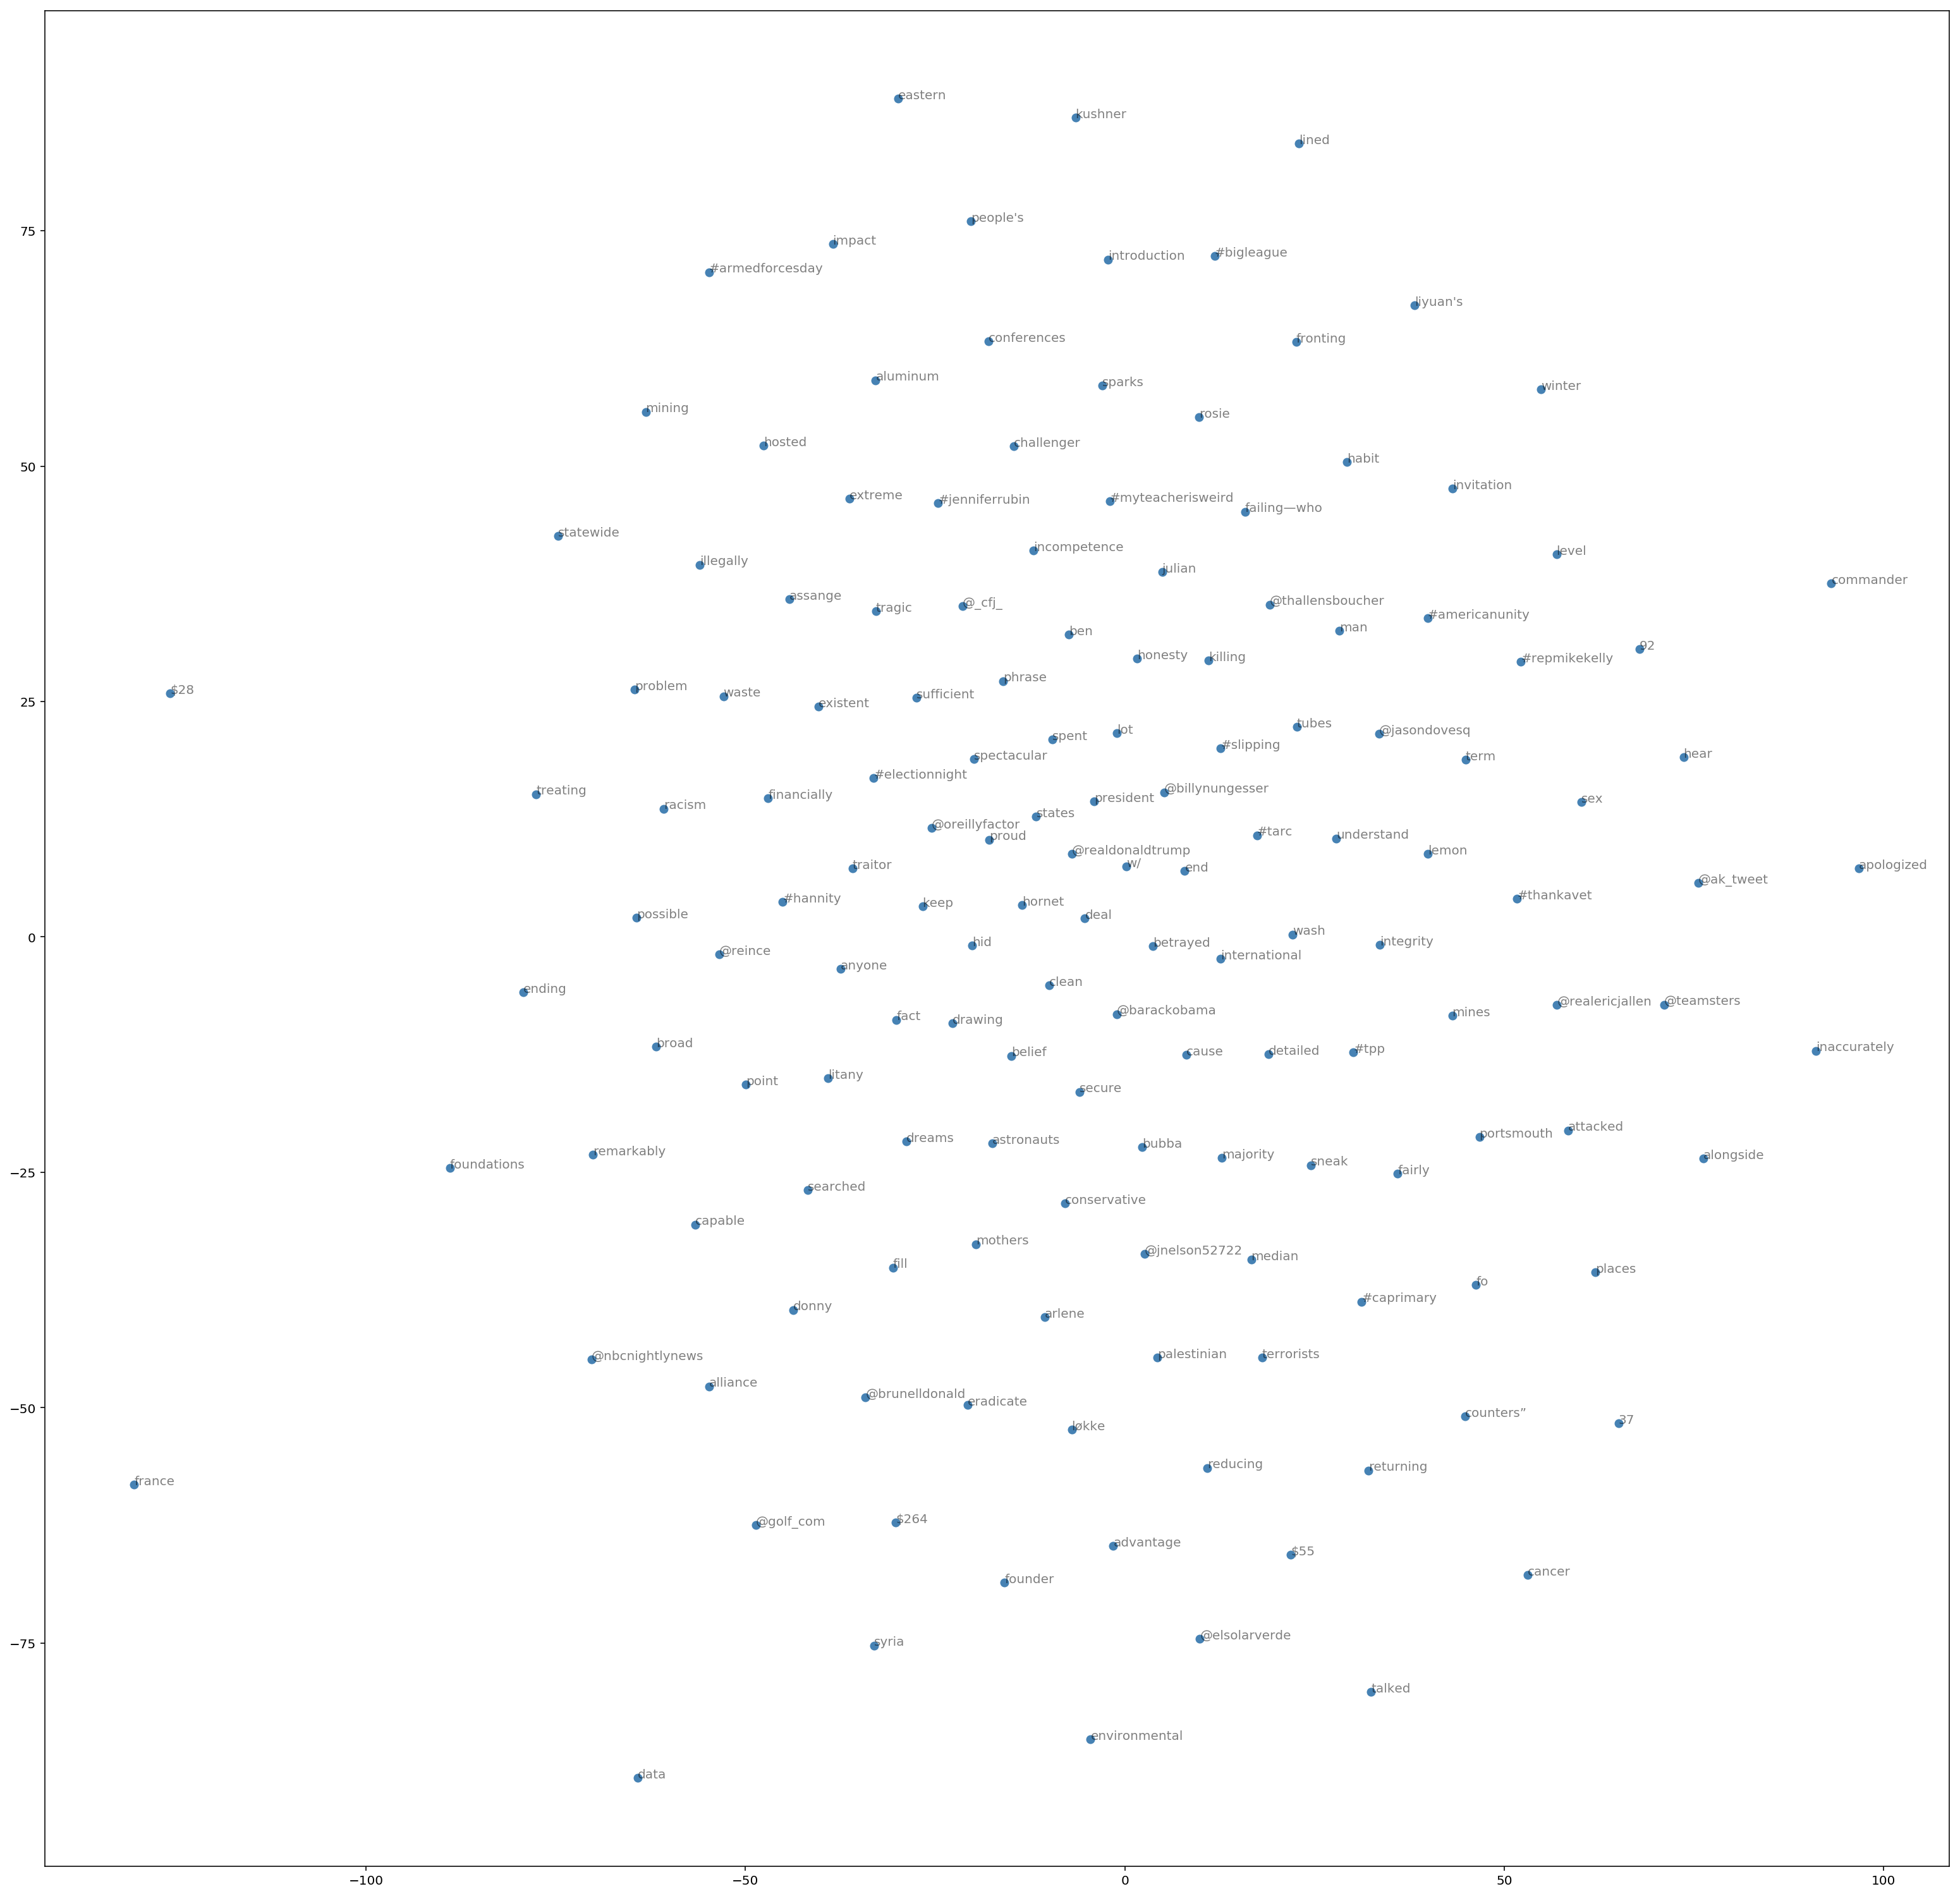

In [38]:
fig, ax = plt.subplots(figsize=(27,27 ))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int2v[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.5)

# Thoughts
1.  After optimizing the data pipeline, the loss from learning the embeddings seems to stick around ~1.45
2.  To improve on this, the first and easiest fix would be to gather more quotes to work with
3.  Another thought would be to include an option in the regex filter to remove @mentions since they appear quite frequently. On that same vein, it might make sense to pull quotes from iPhone and Android separately since the different tweet authors could be confusing the algorithm.
4.  One other approach would be to see about using a seq2seq architecture to learn the relationships between words. Since we are only using a long list of individual words, and each tweet is ~17 words long, it's possible that the algorithm is 'learning' from separate tweets and this would certainly confuse the algorithm. Something to look into for sure.
5.  Regardless of the relatively high loss, the process is efficient enough to scale to larger data sets in the future. For now, the next steps will be to build the seq2seq architecture for tweet generation using the core of what I've built above.